In [3]:
import csv
import subprocess
import getpass
import os
import gzip
from os import listdir
from os.path import isfile, join
from SciServer import Authentication

myUserName = Authentication.getKeystoneUserWithToken(Authentication.getToken()).userName
passwd = getpass.getpass('Password for ' + myUserName + ': ')
userstring = "username=" + myUserName + ",workgroup=win,uid=idies,password=" + passwd
projectname = input("Please enter the name of your SAFE Desktop project folder : ") 
dir = "//cloud.nas.jh.edu/sddesktop$/" + projectname
devnull = open(os.devnull, 'w')
subprocess.run(["sudo", "mkdir", "/home/idies/workspace/SAFE"], capture_output=False)
subprocess.run(["sudo", "chown", "idies:idies", "/home/idies/workspace/SAFE/"], capture_output=False)
try:
    subprocess.run(["sudo", "mount", "-t", "cifs", dir, "/home/idies/workspace/SAFE/", "-o", userstring], stdout=devnull, stderr=devnull)
except FileNotFoundError as e:
    print(e) 

Password for mkim239:  ········
Please enter the name of your SAFE Desktop project folder :  LCICM


mkdir: cannot create directory '/home/idies/workspace/SAFE': File exists


In [44]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

In [45]:
vif_features_combined = list(pd.read_csv("SAFE/vif_features_list.csv").columns)
vif_features_ecg = list(pd.read_csv("SAFE/vif_features_list_ecg.csv").columns)
vif_features_clinical = list(pd.read_csv("SAFE/vif_features_list_clinical.csv").columns)
print(vif_features_clinical)

['HDL', 'tot_cholesterol', 'glucose', 'bnp', 'Arterial Blood Pressure diastolic', 'Arterial Blood Pressure systolic', 'Heart Rate', 'gender', 'race', 'age']


In [46]:
def get_performance(dataset, model, grid, vif):
    df = pd.read_csv("SAFE/complete_features.csv")
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    feature_list = [col for col in vif if col in df]
    # uncomment only for ECG only features
    feature_list.append("nni_counter_lead3")


    print("for HF vs Non-HF")
    X = df[feature_list]
    y = df["hf_original"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)
    imputer = SimpleImputer(strategy="mean")
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    grid_search_model = RandomizedSearchCV(estimator=model, param_distributions=grid, cv=3, verbose=1, n_jobs=-1, n_iter = 3000, scoring = "roc_auc")
    grid_search_model.fit(X_train_scaled, y_train)
    print(grid_search_model.best_params_)

    # show performance
    plot_auroc(grid_search_model.best_estimator_, X_test_scaled, X_train_scaled, y_test, y_train)
    plot_auprc(grid_search_model.best_estimator_, X_test_scaled, X_train_scaled, y_test, y_train)
    calc_f1(grid_search_model.best_estimator_, X_test_scaled, y_test)

    ################################################################################################
    ################################################################################################

    
    print("for HFpEF vs HFrEF")       
    X = df[df["hf_original"] == 1]
    y = X["hf_type_original"]
    X = X[feature_list]
    y = y.replace("HFpEF", 1)
    y = y.replace("HFrEF", 0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)
    imputer = SimpleImputer(strategy="mean")
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    grid_search_model = RandomizedSearchCV(estimator=model, param_distributions=grid, cv=3, verbose=1, n_jobs=-1, n_iter = 3000, scoring = "roc_auc")
    grid_search_model.fit(X_train_scaled, y_train)
    print(grid_search_model.best_params_)

    # show performance
    plot_auroc(grid_search_model.best_estimator_, X_test_scaled, X_train_scaled, y_test, y_train)
    plot_auprc(grid_search_model.best_estimator_, X_test_scaled, X_train_scaled, y_test, y_train)
    calc_f1(grid_search_model.best_estimator_, X_test_scaled, y_test)

    ################################################################################################
    ################################################################################################


    print("for HFpEF vs rest (no HFpEF)")
    
    X = df[feature_list]
    y = df["hf_type_original"]
    y = y.replace("HFpEF", 1)
    y = y.replace("HFrEF", 0)
    y = y.replace("Non-HF", 0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)
    imputer = SimpleImputer(strategy="mean")
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    grid_search_model = RandomizedSearchCV(estimator=model, param_distributions=grid, cv=3, verbose=1, n_jobs=-1, n_iter = 3000, scoring = "roc_auc")
    grid_search_model.fit(X_train_scaled, y_train)
    print(grid_search_model.best_params_)

    # show performance
    plot_auroc(grid_search_model.best_estimator_, X_test_scaled, X_train_scaled, y_test, y_train)
    plot_auprc(grid_search_model.best_estimator_, X_test_scaled, X_train_scaled, y_test, y_train)
    calc_f1(grid_search_model.best_estimator_, X_test_scaled, y_test)

In [47]:
# making a function to produce AUROC given model
def plot_auroc(model, X_test_scaled, X_train_scaled, y_test, y_train):
    # calculate AUROC + AUPRC
    prob_test = model.predict_proba(X_test_scaled)[:, 1]
    prob_train = model.predict_proba(X_train_scaled)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, prob_test)
    fpr_train, tpr_train, _ = roc_curve(y_train, prob_train)
    
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve test (area = %0.2f)" % auc(fpr, tpr))
    plt.plot(fpr_train, tpr_train, color="darkgreen", lw=2, label="ROC curve train (area = %0.2f)" % auc(fpr_train, tpr_train))
    
    plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")


In [48]:
# making a function to produce AUROC given model
from sklearn.metrics import precision_recall_curve
def plot_auprc(model, X_test_scaled, X_train_scaled, y_test, y_train):
    prob_test = model.predict_proba(X_test_scaled)[:, 1]
    prob_train = model.predict_proba(X_train_scaled)[:, 1]
    
    precision, recall, thresholds = precision_recall_curve(y_test, prob_test)
    precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, prob_train)
    
    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, color="darkorange", lw=2, label="AUPRC (area = %0.2f)" % auc(recall, precision))
    plt.plot(recall, precision, color="darkgreen", lw=2, label="AUPRC train (area = %0.2f)" % auc(recall_train, precision_train))    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Recall Precision Curve")
    plt.legend(loc="lower right")

In [49]:
from sklearn.metrics import confusion_matrix, f1_score
def calc_f1(model, X_test_scaled, y_test):
    y_pred = model.predict(X_test_scaled)
    print(f"F1 Score: {f1_score(y_test, y_pred)}")
    cm= confusion_matrix(y_test, y_pred)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")

In [50]:
# for hyperparameter tuning
param_grid_log = {
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "penalty": ["l1", "l2", "elasticnet", "None"],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "fit_intercept": [False, True],
    "max_iter": [300, 350, 400, 450, 500, 550, 600]
}

param_grid_rf = {
    "n_estimators": np.arange(50, 350, 50),
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": np.arange(2, 20, 1),
    "min_samples_split": np.arange(0, 1.05, 0.05),
    "min_samples_leaf": np.arange(0, 1.05, 0.05),
    "min_weight_fraction_leaf": np.arange(0, 0.5, 0.05),
    "max_features": ["sqrt", "log2", None],
    "max_leaf_nodes": [None, 10, 20, 30],
    "bootstrap": [True, False],
    "oob_score": [False, True],
    "max_samples": np.arange(0, 1.05, 0.05),
    "class_weight": [None, "balanced", "balanced_subsample"]
}

param_grid_svm = {
    "C": [0.01, 0.1, 1, 10, 100],
    "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
    "kernel": ["rbf", "linear", "poly", "sigmoid"],
    "degree": [2, 3, 4, 5]
}

param_grid_mlp = {
    "hidden_layer_sizes": [(x,) for x in range(50, 101, 25)] + [(x, x//2) for x in range(50, 101, 25)],
    "activation": ["identity", "tanh", "relu", "logistic"],
    "solver": ["lbfgs", "sgd", "adam"],
    "alpha": [10**-x for x in range(4, 7)],
    "batch_size": [2**x for x in range(6, 9)],
    "learning_rate": ["constant", "invscaling", "adaptive"],
    "learning_rate_init": [10**-x for x in range(3, 6)],
    "max_iter": [1000, 1500, 2000],
    "momentum": [0.9, 0.95, 0.99],
    "early_stopping": [False, True],
    "n_iter_no_change": [10, 20]
}

for HF vs Non-HF
Fitting 3 folds for each of 3000 candidates, totalling 9000 fits
{'oob_score': True, 'n_estimators': 250, 'min_weight_fraction_leaf': 0.15000000000000002, 'min_samples_split': 0.1, 'min_samples_leaf': 0.05, 'max_samples': 0.45, 'max_leaf_nodes': 30, 'max_features': 'sqrt', 'max_depth': 13, 'criterion': 'log_loss', 'class_weight': 'balanced_subsample', 'bootstrap': True}
F1 Score: 0.5008228195282501
Sensitivity: 0.6948249619482496
Specificity: 0.6609318996415771
for HFpEF vs HFrEF
Fitting 3 folds for each of 3000 candidates, totalling 9000 fits
{'oob_score': True, 'n_estimators': 200, 'min_weight_fraction_leaf': 0.05, 'min_samples_split': 0.15000000000000002, 'min_samples_leaf': 0.05, 'max_samples': 0.5, 'max_leaf_nodes': 20, 'max_features': 'sqrt', 'max_depth': 11, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'bootstrap': True}
F1 Score: 0.6332537788385044
Sensitivity: 0.6248037676609105
Specificity: 0.672082717872969
for HFpEF vs rest (no HFpEF)
Fitti

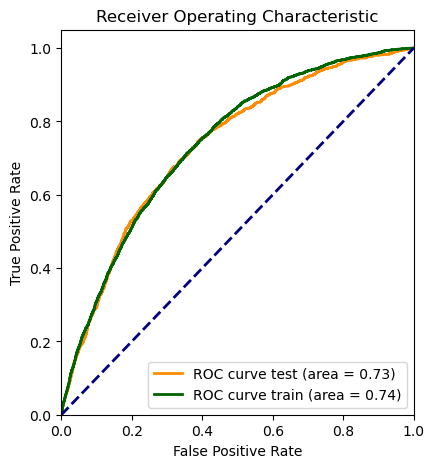

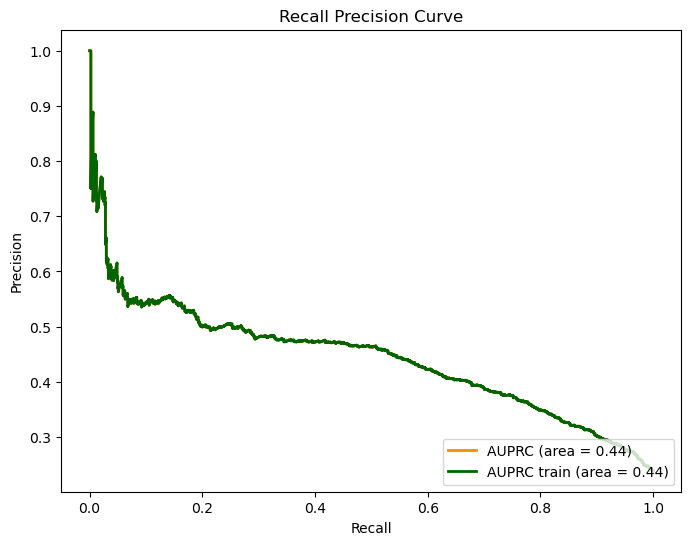

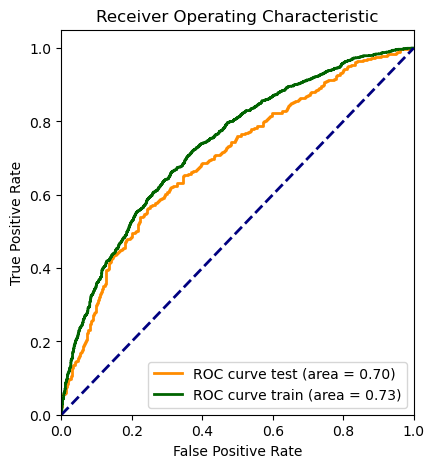

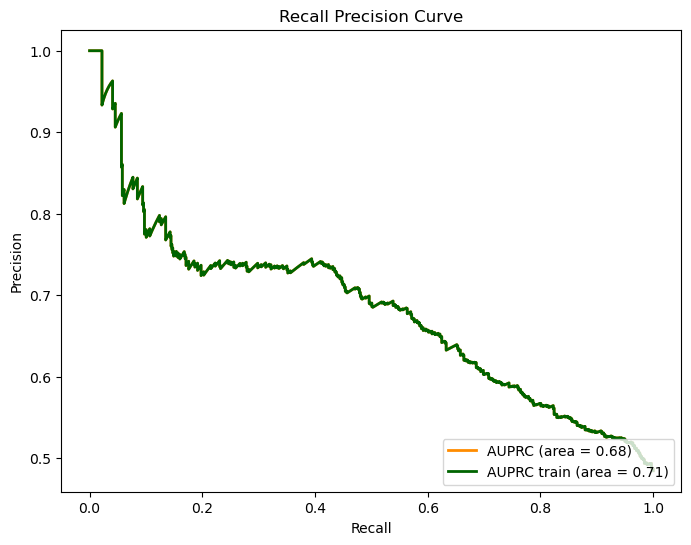

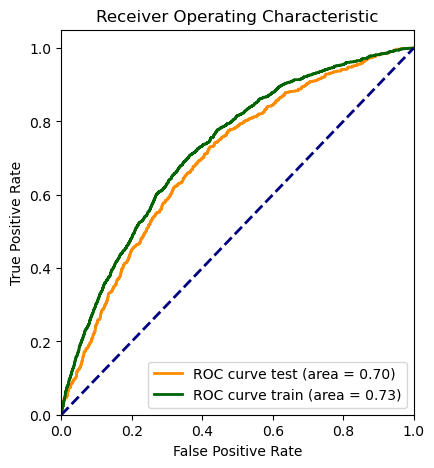

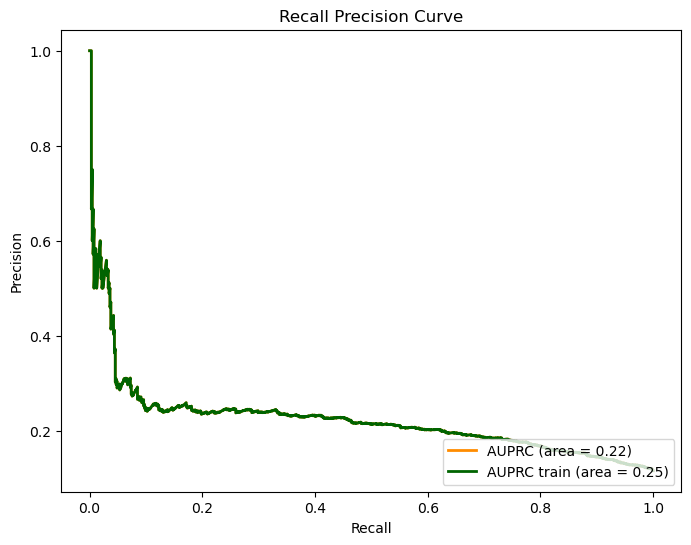

In [38]:
# PERFORMANCE FOR RANDOM FOREST
import warnings
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
rf_model = RandomForestClassifier()

# for ECG + clinical 
get_performance("SAFE/complete_features.csv", rf_model, param_grid_rf)

for HF vs Non-HF
Fitting 3 folds for each of 3000 candidates, totalling 9000 fits
{'oob_score': False, 'n_estimators': 150, 'min_weight_fraction_leaf': 0.05, 'min_samples_split': 0.05, 'min_samples_leaf': 0.05, 'max_samples': 0.5, 'max_leaf_nodes': 30, 'max_features': 'log2', 'max_depth': 15, 'criterion': 'log_loss', 'class_weight': 'balanced', 'bootstrap': True}
F1 Score: 0.4961790393013101
Sensitivity: 0.6917808219178082
Specificity: 0.6556750298685783
for HFpEF vs HFrEF
Fitting 3 folds for each of 3000 candidates, totalling 9000 fits
{'oob_score': False, 'n_estimators': 200, 'min_weight_fraction_leaf': 0.05, 'min_samples_split': 0.2, 'min_samples_leaf': 0.05, 'max_samples': 0.8, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 17, 'criterion': 'entropy', 'class_weight': 'balanced', 'bootstrap': True}
F1 Score: 0.6114942528735633
Sensitivity: 0.6263736263736264
Specificity: 0.6026587887740029
for HFpEF vs rest (no HFpEF)
Fitting 3 folds for each of 3000 candidates, totall

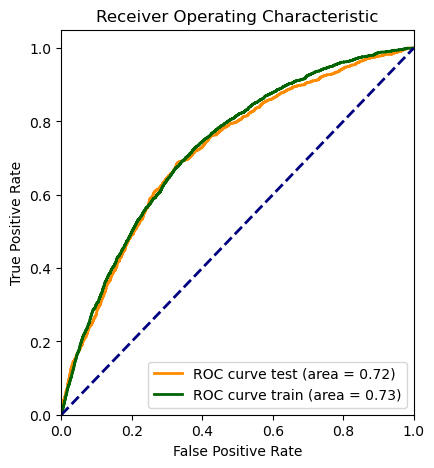

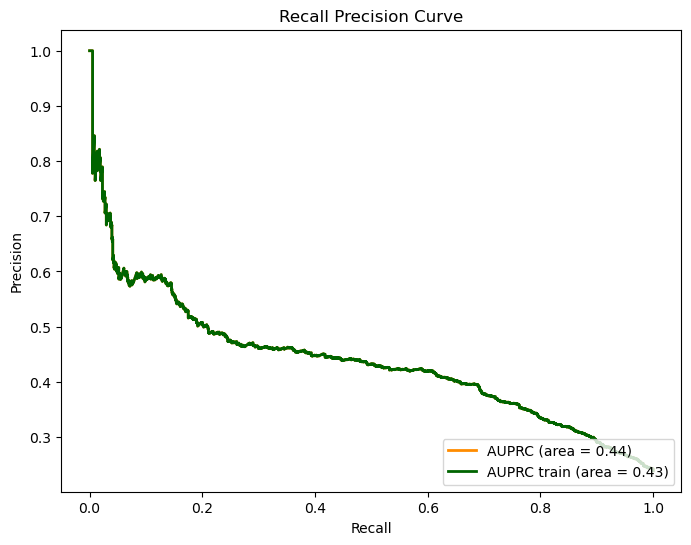

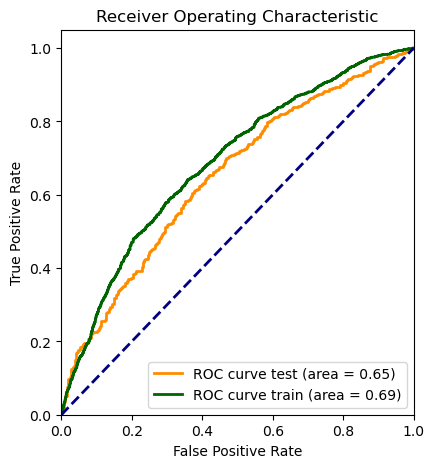

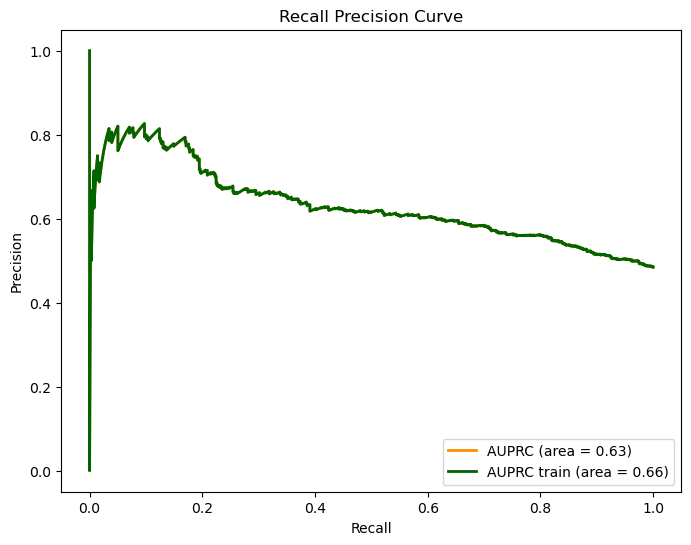

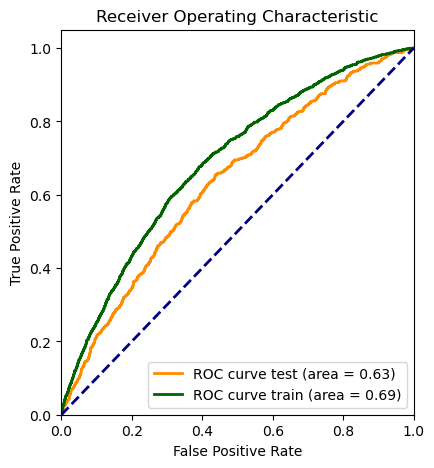

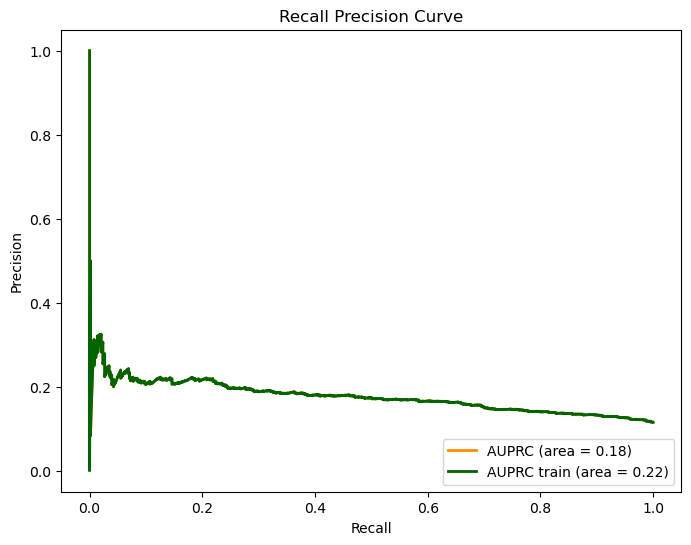

In [56]:
# for ECG only
get_performance("SAFE/ecg_features.csv", rf_model, param_grid_rf, vif_features_ecg)

for HF vs Non-HF
Fitting 3 folds for each of 3000 candidates, totalling 9000 fits
{'oob_score': True, 'n_estimators': 200, 'min_weight_fraction_leaf': 0.05, 'min_samples_split': 0.1, 'min_samples_leaf': 0.05, 'max_samples': 0.9, 'max_leaf_nodes': 30, 'max_features': None, 'max_depth': 3, 'criterion': 'entropy', 'class_weight': None, 'bootstrap': True}
F1 Score: 0.0
Sensitivity: 0.0
Specificity: 1.0
for HFpEF vs HFrEF
Fitting 3 folds for each of 3000 candidates, totalling 9000 fits
{'oob_score': False, 'n_estimators': 50, 'min_weight_fraction_leaf': 0.05, 'min_samples_split': 0.05, 'min_samples_leaf': 0.05, 'max_samples': 0.5, 'max_leaf_nodes': 10, 'max_features': 'sqrt', 'max_depth': 16, 'criterion': 'entropy', 'class_weight': 'balanced_subsample', 'bootstrap': True}
F1 Score: 0.5838011226944667
Sensitivity: 0.5714285714285714
Specificity: 0.6366322008862629
for HFpEF vs rest (no HFpEF)
Fitting 3 folds for each of 3000 candidates, totalling 9000 fits
{'oob_score': True, 'n_estimators':

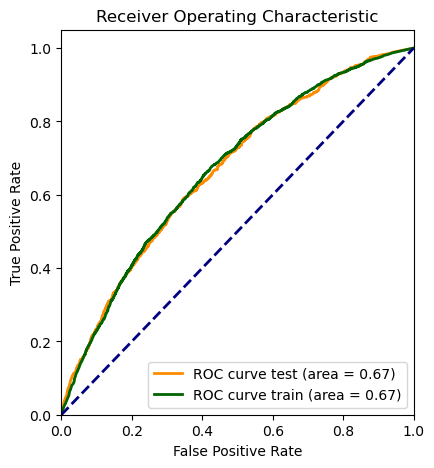

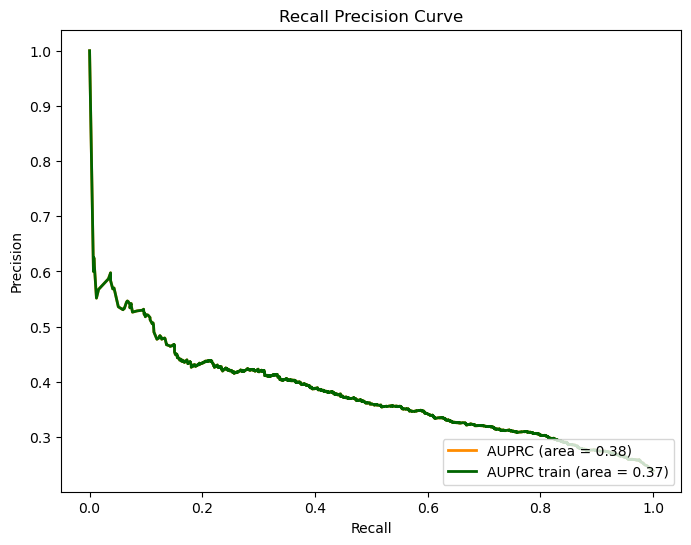

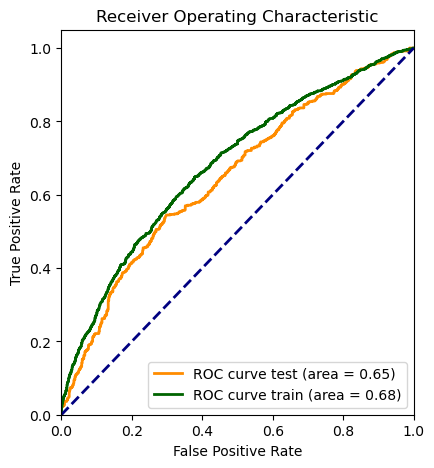

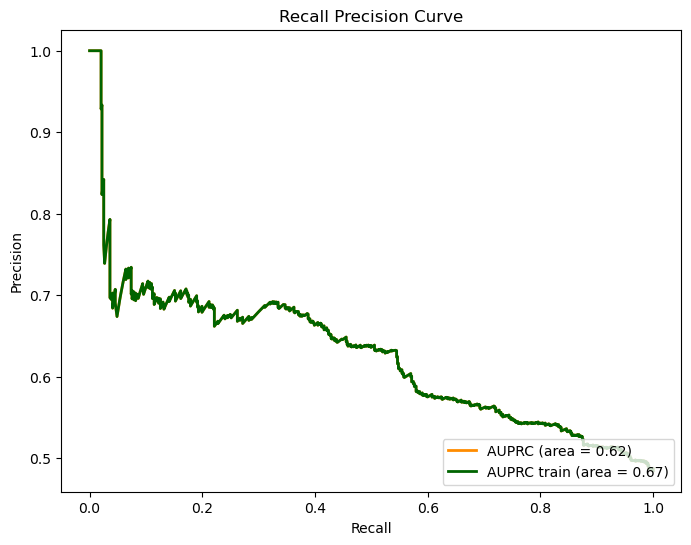

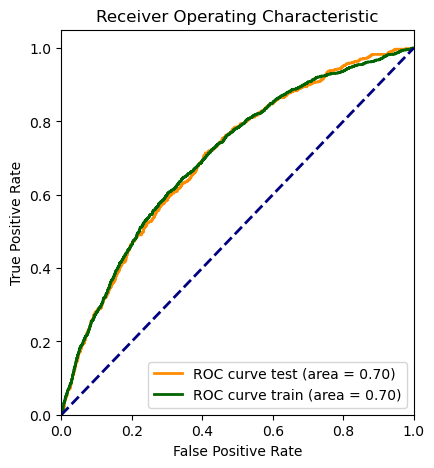

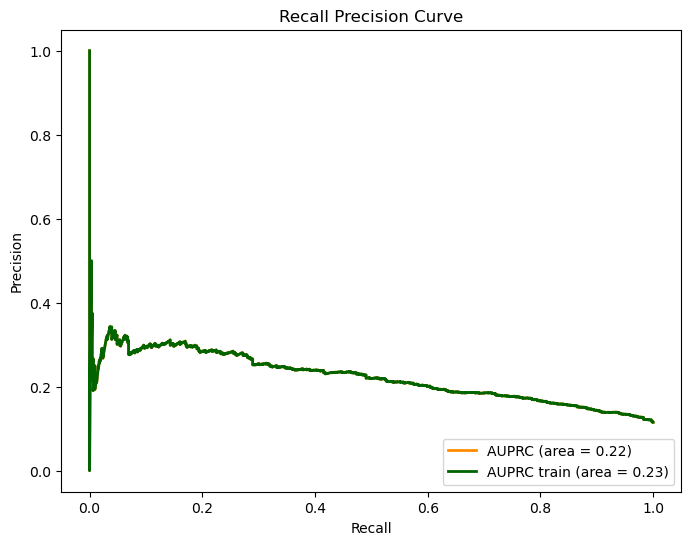

In [58]:
# for clinical only (RF)
get_performance("SAFE/clinical_features.csv", rf_model, param_grid_rf, vif_features_clinical)

In [ ]:
# for CNN
